# Data-Pipelines 📊

## Context and objectives

### The aim of this project is to build a data pipeline to enrich an existing public dataset. For this goal, multiple public datasets from iea.org will be combined together with a database scrapped from a website.


#### As we all know, there is a growing tendency to purchase electric cars. Not only they are becoming popular but also governments are fostering it by providing aids for people to purchase electric cars.

#### This project goal is to democratize data about electric cars evolution and its enviromental and health impac, if any.


#### The chosen scrapped dataset was "World-most-polluted-countries" from iqair.com. The scrapped table provides historical data about the most polluted country and region ranking based on annual average PM2.5 concentration (μg/m³).

####  In order to enrich this dataset, 3 other indicators will be considered and added: 1) charging points around the world, 2) sales cars history, 3) EV stock share and 4) number of deaths by risk factor

The following hypotheses were formulated to guide the analysis:

- The more charging stations, the higher the sales.
- The higher stock share, the higher the sales.
- The higher the sales, the less deaths.
- The more sales, the less the pollution.

iea.org datasets link: https://www.iea.org/data-and-statistics/data-tools/global-ev-data-explorer



## Libraries

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
import requests
from bs4 import BeautifulSoup
import pycountry
import pycountry_convert as pc
import country_converter as coco
import geopandas as gpd
from matplotlib.colors import ListedColormap

In [2]:
chargers=pd.read_csv("data/IEA-EV-dataEV charging pointsEVHistorical.csv")
sales=pd.read_csv("data/IEA-EV-dataEV salesCarsHistorical.csv") 
stock=pd.read_csv("data/IEA-EV-dataEV stock shareCarsHistorical.csv") 
deaths=pd.read_csv("data/number-of-deaths-by-risk-factor.csv") 


In [3]:
    url = "https://www.iqair.com/world-most-polluted-countries"
    html = requests.get(url)
    soup = BeautifulSoup(html.content, "html.parser")
    results=soup.find_all("div", attrs = {"class": "inner-table"})
    pd.set_option('display.max_rows', 10)
    df=pd.read_html(results[0].prettify())[0]
    df

Rank                     Country/Region  2022  2021  2020  2019  2018  \
0       1                               Chad  89.7  75.9     -     -     -   
1       2                               Iraq  80.1  49.7     -  39.6     -   
2       3                           Pakistan  70.9  66.8    59  65.8  74.3   
3       4                            Bahrain  66.6  49.8  39.7  46.8  59.8   
4       5                         Bangladesh  65.8  76.9  77.1  83.3  97.1   
..    ...                                ...   ...   ...   ...   ...   ...   
126   127  Bonaire, Saint Eustatius and Saba   3.3   5.1     -     -     -   
127   128                            Bermuda   3.0     -     -     -     -   
128   129                U.S. Virgin Islands   2.9   4.5   3.7   3.5     -   
129   130                   French Polynesia   2.5     -     -     -     -   
130   131                               Guam   1.3     -     -     -     -   

     Population  
0      17179740  
1      43533592  
2     231402117  
3       1463265  
4     169356251  
..          ...  
126       26221  
127       63867  
128      105870  
129      304032  
130      170534  

[131 rows x 8 columns]

In [4]:
pollution_2 = pd.melt(df, id_vars=['Country/Region', 'Population'], value_vars=['2018', '2019', '2020', '2021', '2022'], var_name='Year', value_name='Pollution')

pd.set_option('display.max_rows', 10)
pollution_2.rename(columns = {"Country/Region": "region", "Population":"population", "Pollution":"pollution", "Year":"year"}, inplace=True)
pollution_2.drop(pollution_2[pollution_2['pollution'] == '-'].index, inplace = True)
pollution_2.dropna()

pollution_2['region'].str.strip()
pollution_2['year'].str.strip()

pollution_2['year'] = pollution_2['year'].astype(int)
pollution_2['pollution'] = pollution_2['pollution'].astype(float)


pollution_2




region  population  year  pollution
2                             Pakistan   231402117  2018       74.3
3                              Bahrain     1463265  2018       59.8
4                           Bangladesh   169356251  2018       97.1
6                               Kuwait     4250114  2018       56.0
7                                India  1407563842  2018       72.5
..                                 ...         ...   ...        ...
650  Bonaire, Saint Eustatius and Saba       26221  2022        3.3
651                            Bermuda       63867  2022        3.0
652                U.S. Virgin Islands      105870  2022        2.9
653                   French Polynesia      304032  2022        2.5
654                               Guam      170534  2022        1.3

[508 rows x 4 columns]

In [5]:
chargers_2= chargers.iloc[:, [0,5, 7]]
chargers_2['region'].str.strip()
chargers_2.rename(columns = {"value":"number of chargers"}, inplace=True)
chargers_3=chargers_2.groupby(['region', 'year'])['number of chargers'].sum()
chargers_3


/var/folders/tb/spjhzdz13378nkrzqyjljkjm0000gn/T/ipykernel_14274/950158494.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chargers_2.rename(columns = {"value":"number of chargers"}, inplace=True)


region          year
Australia       2017      480.0
                2018      731.0
                2019     1950.0
                2020     2350.0
                2021     2320.0
                         ...   
United Kingdom  2018    17700.0
                2019    26700.0
                2020    28200.0
                2021    36700.0
                2022    50600.0
Name: number of chargers, Length: 316, dtype: float64

In [6]:

sales_2= sales.iloc[:, [0,5, 7]]
sales_2.rename(columns = {"value":"sales"}, inplace=True)
sales_2['region'].str.strip()
sales_3=sales_2.groupby(['region', 'year'])['sales'].sum()
sales_3





/var/folders/tb/spjhzdz13378nkrzqyjljkjm0000gn/T/ipykernel_14274/938289633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_2.rename(columns = {"value":"sales"}, inplace=True)


region     year
Australia  2011          49
           2012         250
           2013         290
           2014        1320
           2015        1760
                     ...   
World      2018     2050000
           2019     2080000
           2020     2970000
           2021     6500000
           2022    10200000
Name: sales, Length: 444, dtype: int64

In [7]:
stock_2= stock.iloc[:, [0,5, 7]]
stock_2.rename(columns = {"value":"stock price %"}, inplace=True)
stock_2['region'].str.strip()
stock_2

/var/folders/tb/spjhzdz13378nkrzqyjljkjm0000gn/T/ipykernel_14274/1232069725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_2.rename(columns = {"value":"stock price %"}, inplace=True)


region  year  stock price %
0    Australia  2011        0.00046
1    Australia  2012        0.00280
2    Australia  2013        0.00540
3    Australia  2014        0.01700
4    Australia  2015        0.03200
..         ...   ...            ...
438      World  2018        0.45000
439      World  2019        0.60000
440      World  2020        0.83000
441      World  2021        1.30000
442      World  2022        2.10000

[443 rows x 3 columns]

In [8]:
deaths_2= deaths.iloc[:, [0,2, 3]]
deaths_2.rename(columns = {"Entity": "region", "Deaths - Cause: All causes - Risk: Outdoor air pollution - OWID - Sex: Both - Age: All Ages (Number)":"number of deaths by air pollution", "Year":"year"}, inplace=True)
deaths_2.region.unique()
deaths_2['region'].str.strip()
mask_USA = deaths_2['region'].str.contains('United States', case=False)
deaths_2.loc[mask_USA, 'region'] = 'USA' 
deaths_2
deaths_3=deaths_2.groupby(['region', 'year'])['number of deaths by air pollution'].sum()
deaths_3

/var/folders/tb/spjhzdz13378nkrzqyjljkjm0000gn/T/ipykernel_14274/2123737396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deaths_2.rename(columns = {"Entity": "region", "Deaths - Cause: All causes - Risk: Outdoor air pollution - OWID - Sex: Both - Age: All Ages (Number)":"number of deaths by air pollution", "Year":"year"}, inplace=True)


region       year
Afghanistan  1990    3169
             1991    3222
             1992    3395
             1993    3623
             1994    3788
                     ... 
Zimbabwe     2015    2835
             2016    2781
             2017    2700
             2018    2669
             2019    2680
Name: number of deaths by air pollution, Length: 6810, dtype: int64

In [19]:
deaths_2

region  year  \
0                            Afghanistan  1990   
1                            Afghanistan  1991   
2                            Afghanistan  1992   
3                            Afghanistan  1993   
4                            Afghanistan  1994   
5                            Afghanistan  1995   
6                            Afghanistan  1996   
7                            Afghanistan  1997   
8                            Afghanistan  1998   
9                            Afghanistan  1999   
10                           Afghanistan  2000   
11                           Afghanistan  2001   
12                           Afghanistan  2002   
13                           Afghanistan  2003   
14                           Afghanistan  2004   
15                           Afghanistan  2005   
16                           Afghanistan  2006   
17                           Afghanistan  2007   
18                           Afghanistan  2008   
19                           Afghanistan  2009   
20                           Afghanistan  2010   
21                           Afghanistan  2011   
22                           Afghanistan  2012   
23                           Afghanistan  2013   
24                           Afghanistan  2014   
25                           Afghanistan  2015   
26                           Afghanistan  2016   
27                           Afghanistan  2017   
28                           Afghanistan  2018   
29                           Afghanistan  2019   
30                  African Region (WHO)  1990   
31                  African Region (WHO)  1991   
32                  African Region (WHO)  1992   
33                  African Region (WHO)  1993   
34                  African Region (WHO)  1994   
35                  African Region (WHO)  1995   
36                  African Region (WHO)  1996   
37                  African Region (WHO)  1997   
38                  African Region (WHO)  1998   
39                  African Region (WHO)  1999   
40                  African Region (WHO)  2000   
41                  African Region (WHO)  2001   
42                  African Region (WHO)  2002   
43                  African Region (WHO)  2003   
44                  African Region (WHO)  2004   
45                  African Region (WHO)  2005   
46                  African Region (WHO)  2006   
47                  African Region (WHO)  2007   
48                  African Region (WHO)  2008   
49                  African Region (WHO)  2009   
50                  African Region (WHO)  2010   
51                  African Region (WHO)  2011   
52                  African Region (WHO)  2012   
53                  African Region (WHO)  2013   
54                  African Region (WHO)  2014   
55                  African Region (WHO)  2015   
56                  African Region (WHO)  2016   
57                  African Region (WHO)  2017   
58                  African Region (WHO)  2018   
59                  African Region (WHO)  2019   
60                               Albania  1990   
61                               Albania  1991   
62                               Albania  1992   
63                               Albania  1993   
64                               Albania  1994   
65                               Albania  1995   
66                               Albania  1996   
67                               Albania  1997   
68                               Albania  1998   
69                               Albania  1999   
70                               Albania  2000   
71                               Albania  2001   
72                               Albania  2002   
73                               Albania  2003   
74                               Albania  2004   
75                               Albania  2005   
76                               Albania  2006   
77                               Albania  2007   
78                               Albania  2008   
79                               A

In [10]:
from functools import reduce

data_frames = [pollution_2, sales_3, deaths_3, stock_2, chargers_3]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['region', 'year'], how='outer'), data_frames)

pd.options.display.max_rows = None

In [11]:
df_merged

region    population  year  pollution  \
0                               Pakistan  2.314021e+08  2018       74.3   
1                                Bahrain  1.463265e+06  2018       59.8   
2                             Bangladesh  1.693563e+08  2018       97.1   
3                                 Kuwait  4.250114e+06  2018       56.0   
4                                  India  1.407564e+09  2018       72.5   
5                   United Arab Emirates  9.365145e+06  2018       49.9   
6                                  Nepal  3.003499e+07  2018       54.1   
7                                 Uganda  4.585378e+07  2018       40.8   
8                                Nigeria  2.134013e+08  2018       44.8   
9                     Bosnia Herzegovina  3.270943e+06  2018       40.0   
10                            Uzbekistan  3.491510e+07  2018       34.3   
11                                  Iran  8.792343e+07  2018       25.0   
12                              Ethiopia  1.202830e+08  2018       27.1   
13                                 China  1.412360e+09  2018       41.2   
14                             Indonesia  2.737532e+08  2018       42.0   
15                              Mongolia  3.347782e+06  2018       58.5   
16                               Vietnam  9.746803e+07  2018       32.9   
17                       North Macedonia  2.065092e+06  2018       35.5   
18                                Serbia  6.834326e+06  2018       23.9   
19                               Croatia  3.899000e+06  2018       22.2   
20                                  Peru  3.371547e+07  2018       28.0   
21                            Kazakhstan  1.900099e+07  2018       29.8   
22                                 Chile  1.949318e+07  2018       24.9   
23                                Turkey  8.477540e+07  2018       21.9   
24                             Sri Lanka  2.215600e+07  2018       32.0   
25                                Mexico  1.267051e+08  2018       20.3   
26                                 Italy  5.910967e+07  2018       14.9   
27                                Israel  9.364000e+06  2018       18.6   
28                              Bulgaria  6.877743e+06  2018       25.8   
29                           South Korea  5.174488e+07  2018       24.0   
30                              Thailand  7.160110e+07  2018       26.4   
31                               Romania  1.911988e+07  2018       18.6   
32                                Poland  3.774712e+07  2018       22.4   
33                              Colombia  5.151656e+07  2018       13.9   
34                                Cyprus  1.244188e+06  2018       17.6   
35                             Macao SAR  6.866070e+05  2018       21.2   
36                           Philippines  1.138803e+08  2018       14.6   
37                                Kosovo  1.786038e+06  2018       30.4   
38                              Slovakia  5.447247e+06  2018       18.5   
39                         Hong Kong SAR  7.413100e+06  2018       20.2   
40                        Czech Republic  1.050577e+07  2018       20.2   
41                                Taiwan  2.381678e+07  2018       18.5   
42                             Singapore  5.453566e+06  2018       14.8   
43                             Lithuania  2.800839e+06  2018       17.5   
44                               Hungary  9.709891e+06  2018       16.8   
45                                Brazil  2.143262e+08  2018       16.3   
46                                 Malta  5.185360e+05  2018       11.0   
47                                France  6.774963e+07  2018       13.2   
48                                Russia  1.434493e+08  2018       11.4   
49                           Netherlands  1.753304e+07  2018       11.7   
50                               Germany  8.319608e+07  2018       13.0   
51                                 Spain  4.741575e+07  2018       10.3   
52                               Belgium  1.159295e+07  201

# Visualization

## Visualizations of the correlation matrix

In [12]:
correlation_matrix=df_merged.corr()
correlation_matrix

/var/folders/tb/spjhzdz13378nkrzqyjljkjm0000gn/T/ipykernel_14274/3398150142.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix=df_merged.corr()


population      year  pollution     sales  \
population                           1.000000 -0.049263   0.300600  0.524559   
year                                -0.049263  1.000000  -0.073423  0.232207   
pollution                            0.300600 -0.073423   1.000000  0.210416   
sales                                0.524559  0.232207   0.210416  1.000000   
number of deaths by air pollution    0.969380  0.047881   0.323321  0.672065   
stock price %                       -0.105458  0.360650  -0.254547  0.100002   
number of chargers                   0.580830  0.165854   0.236862  0.957852   

                                   number of deaths by air pollution  \
population                                                  0.969380   
year                                                        0.047881   
pollution                                                   0.323321   
sales                                                       0.672065   
number of deaths by air pollution                           1.000000   
stock price %                                              -0.039836   
number of chargers                                          0.646392   

                                   stock price %  number of chargers  
population                             -0.105458            0.580830  
year                                    0.360650            0.165854  
pollution                              -0.254547            0.236862  
sales                                   0.100002            0.957852  
number of deaths by air pollution      -0.039836            0.646392  
stock price %                           1.000000            0.107142  
number of chargers                      0.107142            1.000000

# Is there any correlation at all?

### we can clearly see there is a clear correlation between population and number of deaths.
### There is also a strong positive correlation between sales and number of chargers.
### We can also infer that higher EV sales doesn't imply lower pollution, but we would need more data in order to take conclusions out of this.

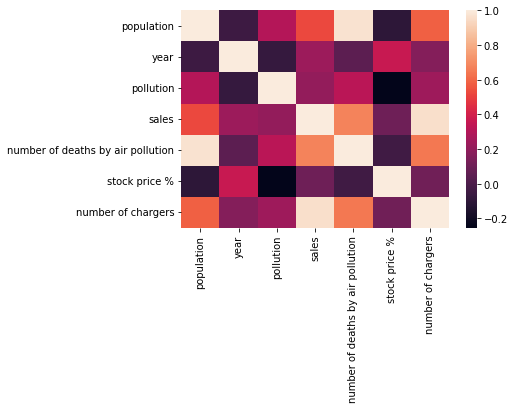

In [13]:
sns.heatmap(correlation_matrix);

## Visualizations of contamination index, sales, chargers and number of deaths caused by pollution  around the globe

In [14]:

map_1=df_merged[["region", "year", "pollution"]].groupby("region").agg({"pollution":"mean"})

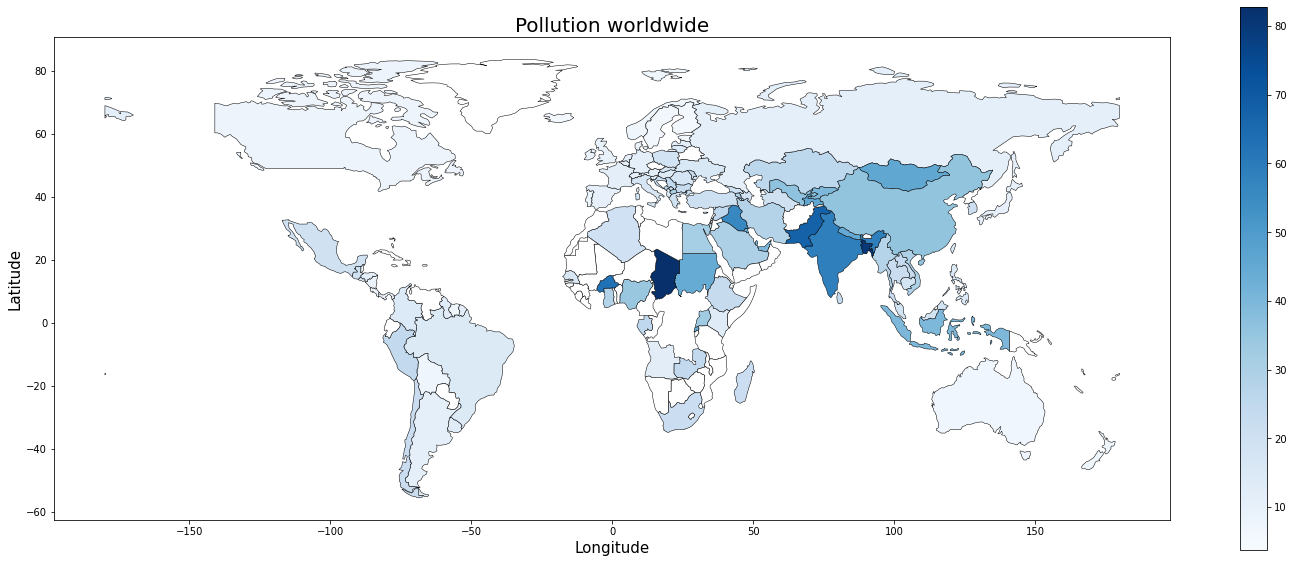

In [15]:


# Load shapefile of world countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


# Merge dataframe with shapefile using country names as the key
merged = world.merge(map_1, left_on='name', right_on='region')


# Create choropleth map using population data
ax = merged.plot(column='pollution', cmap='Blues', figsize=(25, 10), edgecolor='black', linewidth=0.5, missing_kwds={'color': 'white'}, legend=True)


# Add title and axis labels
ax.set_title('Pollution worldwide', fontsize=20)
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)

# Display map
plt.show()

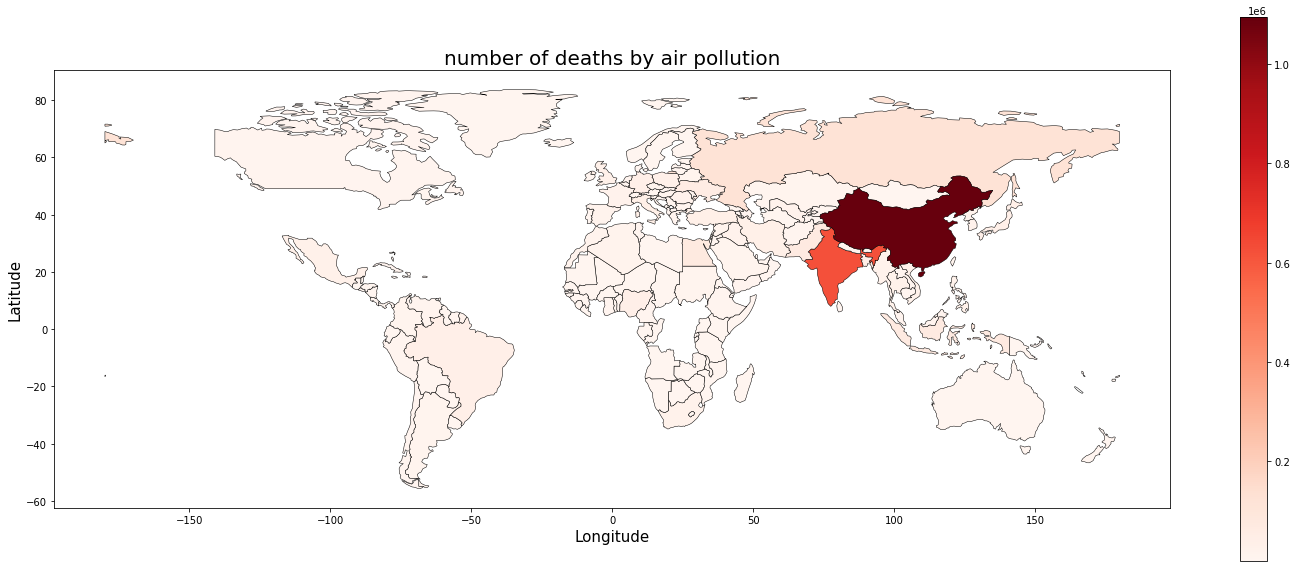

In [16]:
latest_data = df_merged[['region', 'year', 'number of deaths by air pollution']].groupby('region').agg({"number of deaths by air pollution":"mean"})



# Load shapefile of world countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


# Merge dataframe with shapefile using country names as the key
merged = world.merge(latest_data, left_on='name', right_on='region')


# Create choropleth map using population data
ax = merged.plot(column='number of deaths by air pollution', cmap='Reds', figsize=(25, 10), edgecolor='black', linewidth=0.5, missing_kwds={'color': 'white'}, legend=True)


# Add title and axis labels
ax.set_title('number of deaths by air pollution', fontsize=20)
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)

# Display map
plt.show()

# The higher the chargers, the higher the sales?

Text(0.5, 1.05, 'Sales vs number of chargers')

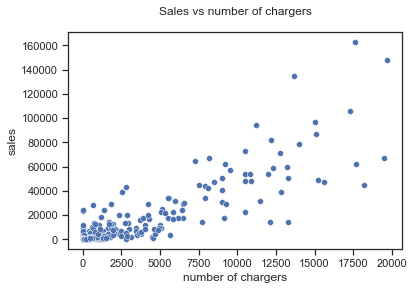

In [17]:
condition_1 = df_merged['number of chargers'] < 20000

sns.set(style="ticks")
chargers_plot=df_merged[condition_1]
sns.scatterplot(x="number of chargers", y="sales", data=chargers_plot)
plt.title("Sales vs number of chargers", y=1.05)




# The higher the sales, the less pollution?

Text(0.5, 1.05, 'Sales vs pollution')

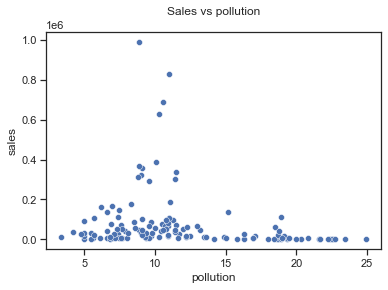

In [18]:
sns.set(style="ticks")
condition_2 = df_merged['pollution'] < 30
pollution_plot=df_merged[condition_2]
sns.scatterplot(x="pollution", y="sales", data=pollution_plot)
plt.title("Sales vs pollution", y=1.05)